In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
sns.set() # Prettier graphs.

In [2]:
credit_df = pd.read_csv(r"C:\Users\Bstaj\Documents\Python Scripts\archive(3)\card_transdata.csv")

In [3]:
credit_df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


## Splitting the Dataset

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
credit_data = credit_df.copy() # Copying the dataset for training/testing.

In [6]:
feature_names = list(credit_data.columns[:-1])
features = credit_data[feature_names]

targets = credit_data["fraud"]

x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size = 0.20) # splitting the data.

## Visualizing the numerical data

This dataset contains both numerical and categorical data, gonna do some visulizing on the numerical data first to see if it shows groupings/clusters.

In [7]:
def plot_2d_scatter(feature_1, feature_2, feature_3, marker_s):
    
    plt.figure(figsize = (16, 10))
    plt.tight_layout(pad = 2)
    
    plt.subplot(2, 2, 1)
    plt.scatter(feature_1, feature_2, marker = "d", s = marker_s, c = "red")
    
    plt.subplot(2, 2, 2)
    plt.scatter(feature_1, feature_3, marker = "d", s = marker_s, c = "red")
    
    plt.subplot(2, 2, 3)
    plt.scatter(feature_2, feature_3, marker = "d", s = marker_s, c = "red")
    
    return plt.show()

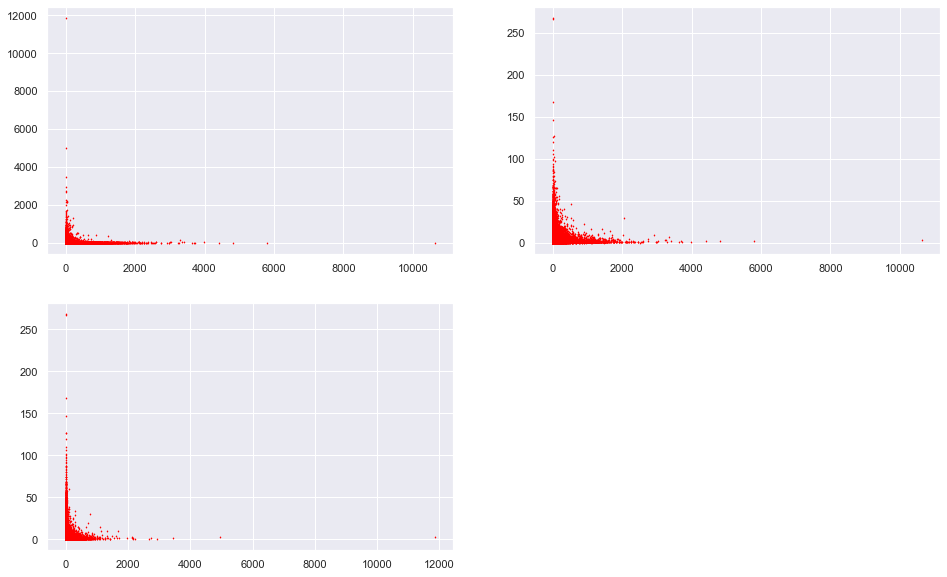

In [8]:
num_feat_1 = x_train["distance_from_home"]
num_feat_2 = x_train["distance_from_last_transaction"]
num_feat_3 = x_train["ratio_to_median_purchase_price"]

plot_2d_scatter(feature_1 = num_feat_1, feature_2 = num_feat_2, feature_3 = num_feat_3, marker_s = 0.5)

## Data cleaning for numerical attributes

Has can be observed from above the data is scaled poorly, needs to be preprocessed.

In [9]:
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline # Incase we need to automate the processes.

In [10]:
numerical_features_names = ["distance_from_home", "distance_from_last_transaction", "ratio_to_median_purchase_price"]

numerical_features = x_train[numerical_features_names]

data_norm = Normalizer()

In [11]:
transformed_features = data_norm.fit_transform(X = numerical_features)

In [12]:
transformed_features # Sklearn outputs an array instead of a pands df.

array([[0.99596681, 0.02656167, 0.08570056],
       [0.99999569, 0.00264545, 0.00127257],
       [0.99923888, 0.02086724, 0.03295771],
       ...,
       [0.999724  , 0.02245438, 0.00690848],
       [0.4681137 , 0.883139  , 0.03057877],
       [0.2432906 , 0.95534889, 0.16768478]])

In [13]:
trans_dist_home = transformed_features[:, 0]
trans_dist_transact = transformed_features[:, 1]
ratio_to_med_price = transformed_features[:, 2]

## More Data Visualization

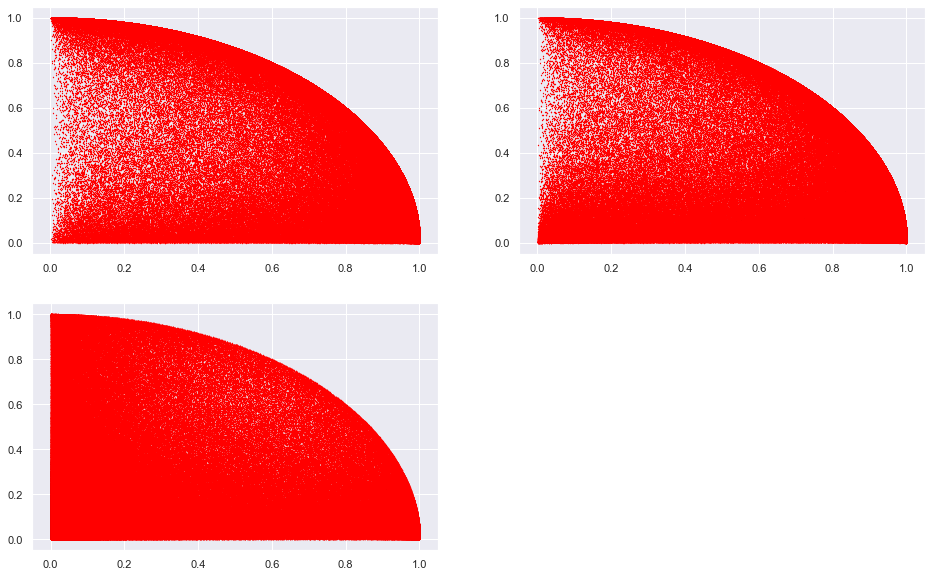

In [14]:
plot_2d_scatter(feature_1 = trans_dist_home, feature_2 = trans_dist_transact, feature_3 = ratio_to_med_price, marker_s = 0.2)
# Yuck.

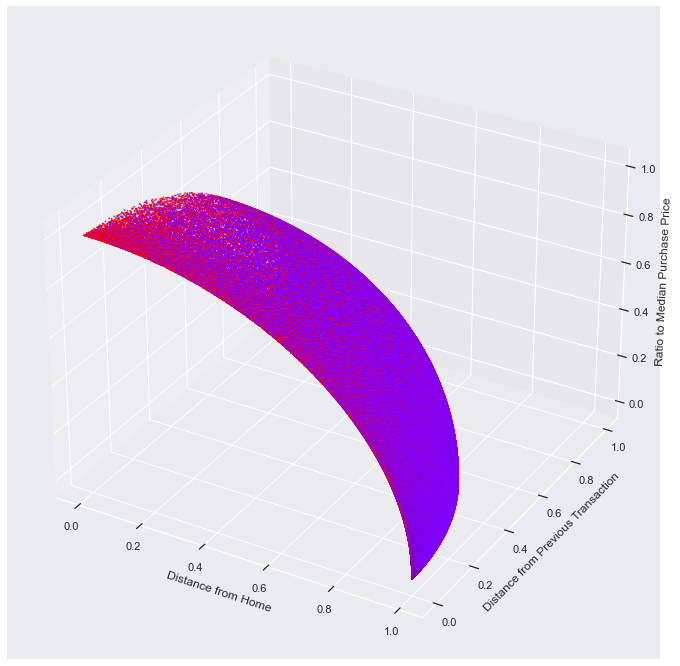

In [15]:
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(projection = "3d") # 3d scatter to visualize each numerical feature.

ax.scatter(xs = trans_dist_home, ys = trans_dist_transact, zs = ratio_to_med_price, s = 0.6, c = y_train, cmap = "rainbow")

ax.set_xlabel(xlabel = "Distance from Home")
ax.set_ylabel(ylabel = "Distance from Previous Transaction")
ax.set_zlabel(zlabel = "Ratio to Median Purchase Price")


plt.show()

Data doesn't look linear seperable (For a Linear SVM Model), however it does look like there is a pattern that could be captured for prediction. KNN could be useful here with well tweaked hyperparameters, also Logistic Regression. KNN may also be useful for the categorical features, will try that first.

## Bit More Data Processing

In [16]:
categorical_feature_names = ["repeat_retailer", "used_chip", "used_pin_number", "online_order"]

categorical_features = x_train[categorical_feature_names] # Isolating the categorical features.

In [17]:
nump_categorical_features = categorical_features.to_numpy()

## Training a Categorical Naive Bayes Model

In [18]:
from sklearn.naive_bayes import CategoricalNB # Categorical Naive Bayes.

In [19]:
clf_naive_bayes = CategoricalNB()

In [20]:
y_target = y_train.to_numpy()

clf_naive_bayes.fit(X = nump_categorical_features, y = y_target)

CategoricalNB()

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [24]:
y_predict_NB = clf_naive_bayes.predict(X = nump_categorical_features)

conf_mat_NB = confusion_matrix(y_true = y_target, y_pred = y_predict_NB) # confusion matrix.

print(conf_mat_NB)

[[729905      0]
 [ 70095      0]]


In [27]:
prec_score_NB = precision_score(y_true = y_target, y_pred = y_predict_NB, zero_division = 0)
rec_score_NB = recall_score(y_true = y_target, y_pred = y_predict_NB)

print(prec_score_NB)
print(rec_score_NB)

0.0
0.0


Useless, categorical features couldnt predict even a single target class from the training set. Will stick with the numerical features and try some of the other suggested models.

## Training a KNN Model

In [28]:
clf_KNN = KNeighborsClassifier(n_neighbors = 10) # Setting the n_neighbors hyperparameter high for first test.

In [29]:
clf_KNN.fit(X = transformed_features, y = y_target)

KNeighborsClassifier(n_neighbors=10)

In [30]:
y_predict_KNN = clf_KNN.predict(X = transformed_features)

In [31]:
conf_mat_KNN = confusion_matrix(y_true = y_target, y_pred = y_predict_KNN)

print(conf_mat_KNN)

[[726770   3135]
 [ 63727   6368]]


In [32]:
prec_score_KNN = precision_score(y_true = y_target, y_pred = y_predict_KNN)
rec_score_KNN = recall_score(y_true = y_target, y_pred = y_predict_KNN)

print(prec_score_KNN)
print(rec_score_KNN)

0.6701041776281175
0.0908481346743705


Reasonable precision, terrible recall. Need to adjust the hyperparamaters to fix this, will do after I test another model.

In [33]:
def f1_score(precision, recall):
    """Takes precision and recall as inputs and returns the f1 score of that particular classifier."""
    
    f1_score = 2*((precision*recall)/(precision + recall))
    
    return f1_score

In [34]:
f1_score(precision = prec_score_KNN, recall = rec_score_KNN)

0.1600040202015126

In [35]:
clf_KNN.predict_proba(X = transformed_features)

array([[1. , 0. ],
       [0.6, 0.4],
       [1. , 0. ],
       ...,
       [0.9, 0.1],
       [1. , 0. ],
       [1. , 0. ]])

## Training a Logistic Regression Model

Note: although this model is tagged as regression it is actually a classification algorithm.

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
clf_logistic_reg = LogisticRegression()

In [38]:
clf_logistic_reg.fit(X = transformed_features, y = y_target)

LogisticRegression()

In [39]:
y_predict_LR = clf_logistic_reg.predict(X = transformed_features)

In [43]:
conf_mat_LR = confusion_matrix(y_true = y_target, y_pred = y_predict_LR) # Confusion Matrix for the Logit model.

print(conf_mat_LR)

[[723439   6466]
 [ 63389   6706]]


In [44]:
prec_score_LR = precision_score(y_true = y_target, y_pred = y_predict_LR) # Precision.
rec_score_LR = recall_score(y_true = y_target, y_pred = y_predict_LR) # Recall.

print(prec_score_LR)
print(rec_score_LR)

0.509110233829335
0.09567016192310436


In [45]:
f1_score(precision = prec_score_LR, recall = rec_score_LR) # f1 score for the logit model.

0.16107221348193163

Because of the higher recall for the logit model, it produces a higher f1 score than the KNN model. However with hyperpramater tweaking for the KNN it should perform better than this.

This logit model may perform better if we select specific features instead of all of them, will try that later.

In [46]:
clf_logistic_reg.predict_proba(X = transformed_features) # Class probabilities for the logit model.

array([[0.9282343 , 0.0717657 ],
       [0.92641683, 0.07358317],
       [0.9291005 , 0.0708995 ],
       ...,
       [0.93010239, 0.06989761],
       [0.96045242, 0.03954758],
       [0.92708877, 0.07291123]])

## Training a Decision Tree Model

In [47]:
clf_decision_tree = DecisionTreeClassifier(max_depth = 5) # Max_depth arbitrarily set to 5.

In [48]:
clf_decision_tree.fit(X = transformed_features, y = y_target)

DecisionTreeClassifier(max_depth=5)

In [49]:
y_predict_DT = clf_decision_tree.predict(X = transformed_features)

In [50]:
conf_mat_DT = confusion_matrix(y_true = y_target, y_pred = y_predict_DT) # Confusion matrix for the Decision Tree model.

print(conf_mat_DT)

[[727627   2278]
 [ 66606   3489]]


In [52]:
prec_score_DT = precision_score(y_true = y_target, y_pred = y_predict_DT) # Precision for the DT model.
rec_score_DT = recall_score(y_true = y_target, y_pred = y_predict_DT) # Recall for the DT model.

print(prec_score_DT)
print(rec_score_DT)

0.6049939309866482
0.04977530494329125


In [54]:
f1_score(precision = prec_score_DT, recall = rec_score_DT) # f1 score for the model.

0.09198281089346445

Alright precision, abysmal recall, gonna adjust some of the hyperparameters to see if this can be improved. If not will not bother short listing this model,